In [44]:
import pandas as pd

# column selection

file_path = 'raw_datasets/main_dataset/forecasts_and_truth.csv'

df_main = pd.read_csv(file_path)

columns_to_keep = [
    'target_end_date', 'forecast_date', 'team_model', 'model_type', 'model_type.general', 'location', 'location_name', 'geo_type',
    'abbreviation', 'population', 'forecast_value',
    'truth_value', 'abs_error', 'forecast_week', 'target_week'
]

filtered_df_main = df_main[columns_to_keep]

filtered_df_main.to_csv('proccesed_data/filtered_main_dataset.csv', index=False)

In [33]:
# unique truth values

df_fmain = pd.read_csv('proccesed_data/filtered_main_dataset.csv')

df_fmain = df_fmain[df_fmain['location_name'] != 'United States']

grouped_df_fmain = df_fmain.groupby(['target_end_date', 'location_name']).agg({
    'truth_value': 'first',
    'abbreviation': 'first'
}).reset_index()

grouped_df_fmain.to_csv('proccesed_data/unique_truth_main_dataset.csv', index=False)

In [34]:
# filtering mobility

df_mobility = pd.read_csv('raw_datasets/supplementary_dataset/mobility.csv')

df_mobility = df_mobility[df_mobility['location_key'].fillna('placeholder').str.startswith('US')]

In [35]:
# filtering vaccination

df_vaccinations = pd.read_csv('raw_datasets/supplementary_dataset/vaccinations.csv')

df_vaccinations = df_vaccinations[df_vaccinations['location_key'].fillna('placeholder').str.startswith('US')]

columns_to_keep = [
    'date', 'location_key', 'cumulative_persons_vaccinated'
]

df_vaccinations = df_vaccinations[columns_to_keep]

In [36]:
# filtering hospitalizations

df_hospitalizations = pd.read_csv('raw_datasets\supplementary_dataset\hospitalizations.csv')
 
df_hospitalizations = df_hospitalizations[df_hospitalizations['location_key'].fillna('placeholder').str.startswith('US')]

columns_to_keep = [
    'date', 'location_key', 'new_hospitalized_patients'
]

df_hospitalizations = df_hospitalizations[columns_to_keep]

In [37]:
abbreviations = pd.read_csv('proccesed_data/unique_truth_main_dataset.csv')['abbreviation'].unique()

abbreviations = ["US_" + abbreviation for abbreviation in abbreviations]

def match_and_replace(location_key):
    if location_key in abbreviations:
        return location_key
    else:
        return None

In [38]:
# key matching mobility

df_mobility = df_mobility.groupby(['date', 'location_key']).mean().reset_index()

df_mobility['matched_location_key'] = df_mobility['location_key'].apply(match_and_replace)

df_mobility = df_mobility.dropna(subset=['matched_location_key'])

df_mobility['location_key'] = df_mobility['matched_location_key']

df_mobility = df_mobility.drop(columns=['matched_location_key'])

df_mobility.head()

,date,location_key,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
1,2020-02-15,US_AK,5.0,3.0,14.0,2.0,1.0,0.0
7,2020-02-15,US_AL,5.0,2.0,39.0,7.0,2.0,-1.0
74,2020-02-15,US_AR,3.0,2.0,8.0,-3.0,1.0,0.0
139,2020-02-15,US_AZ,3.0,2.0,13.0,3.0,-1.0,0.0
155,2020-02-15,US_CA,1.0,1.0,19.0,1.0,-1.0,0.0


In [39]:
# key matching vaccinations

df_vaccinations['matched_location_key'] = df_vaccinations['location_key'].apply(match_and_replace)

df_vaccinations = df_vaccinations.dropna(subset=['matched_location_key'])

df_vaccinations['location_key'] = df_vaccinations['matched_location_key']

df_vaccinations = df_vaccinations.drop(columns=['matched_location_key'])

df_vaccinations.head()

,date,location_key,cumulative_persons_vaccinated
917598,2021-01-12,US_AK,22486.0
917599,2021-01-13,US_AK,24541.0
917600,2021-01-14,US_AK,35508.0
917601,2021-01-15,US_AK,39546.0
917602,2021-01-19,US_AK,55434.0


In [40]:
# key matching hospitalizations

df_hospitalizations['matched_location_key'] = df_hospitalizations['location_key'].apply(match_and_replace)

df_hospitalizations = df_hospitalizations.dropna(subset=['matched_location_key'])

df_hospitalizations['location_key'] = df_hospitalizations['matched_location_key']

df_hospitalizations = df_hospitalizations.drop(columns=['matched_location_key'])

df_hospitalizations.head()

,date,location_key,new_hospitalized_patients
1711321,2020-03-06,US_AK,0.0
1711322,2020-03-07,US_AK,0.0
1711323,2020-03-08,US_AK,0.0
1711324,2020-03-09,US_AK,1.0
1711325,2020-03-10,US_AK,0.0


In [41]:
# merging mobility, vaccinations and hospitalizations

merged_df = pd.merge(df_mobility, df_vaccinations, on=['date', 'location_key'], how='outer', suffixes=('_df1', '_df2'))

final_merged_df = pd.merge(merged_df, df_hospitalizations, on=['date', 'location_key'], how='outer', suffixes=('', '_df3'))

final_merged_df.sort_values(by=['date', 'location_key'], inplace=True)

final_merged_df = final_merged_df.dropna()

final_merged_df.to_csv('proccesed_data/merged_dataset.csv', index=False)

final_merged_df.head()

,date,location_key,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,cumulative_persons_vaccinated,new_hospitalized_patients
16932,2021-01-12,US_AK,-17.0,-11.0,-4.0,-35.0,-24.0,11.0,22486.0,7.0
16933,2021-01-12,US_AL,-15.0,-7.0,-25.0,-15.0,-24.0,9.0,70861.0,436.0
16934,2021-01-12,US_AR,-14.0,-5.0,8.0,-7.0,-23.0,8.0,39357.0,176.0
16935,2021-01-12,US_AZ,-21.0,-11.0,-26.0,-30.0,-37.0,13.0,95141.0,545.0
16936,2021-01-12,US_CA,-35.0,-15.0,-25.0,-51.0,-44.0,16.0,703540.0,2221.0


In [42]:
# merge with main dataset

unique_truth = pd.read_csv('proccesed_data/unique_truth_main_dataset.csv')

unique_truth.rename(columns={'target_end_date': 'date', 'abbreviation': 'location_key'}, inplace=True)

unique_truth['location_key'] = 'US_' + unique_truth['location_key']

final_merged_df = pd.merge(final_merged_df, unique_truth, on=['date', 'location_key'], how='outer', suffixes=('_left', '_right'))

final_merged_df.head()

,date,location_key,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,cumulative_persons_vaccinated,new_hospitalized_patients,location_name,truth_value
0,2021-01-12,US_AK,-17.0,-11.0,-4.0,-35.0,-24.0,11.0,22486.0,7.0,Alaska,15.0
1,2021-01-12,US_AL,-15.0,-7.0,-25.0,-15.0,-24.0,9.0,70861.0,436.0,Alabama,416.0
2,2021-01-12,US_AR,-14.0,-5.0,8.0,-7.0,-23.0,8.0,39357.0,176.0,Arkansas,189.0
3,2021-01-12,US_AZ,-21.0,-11.0,-26.0,-30.0,-37.0,13.0,95141.0,545.0,Arizona,616.0
4,2021-01-12,US_CA,-35.0,-15.0,-25.0,-51.0,-44.0,16.0,703540.0,2221.0,California,2236.0


In [43]:
final_merged_df = final_merged_df.dropna()

final_merged_df.to_csv('proccesed_data/final_merged_dataset.csv', index=False)

In [46]:
# regression on US_AK

import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

df = pd.read_csv('proccesed_data/final_merged_dataset.csv')

# Assuming df is your DataFrame
df_ak = df[df['location_key'] == 'US_AK'].copy()

# Convert 'date' from string to datetime, then to ordinal to use as a numerical variable
df_ak['date'] = pd.to_datetime(df_ak['date'])
df_ak['date_ordinal'] = df_ak['date'].apply(lambda x: x.toordinal())

# Prepare independent variables (excluding 'location_key', 'location_name')
X = df_ak[['date_ordinal', 'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy',
           'mobility_parks', 'mobility_transit_stations', 'mobility_workplaces',
           'mobility_residential', 'cumulative_persons_vaccinated', 'new_hospitalized_patients']]
# Add a constant for the intercept
X = sm.add_constant(X)

# Prepare the dependent variable
y = df_ak['truth_value']

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            truth_value   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     8.842
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           4.42e-12
Time:                        05:37:31   Log-Likelihood:                -3361.1
No. Observations:                 379   AIC:                             6742.
Df Residuals:                     369   BIC:                             6782.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

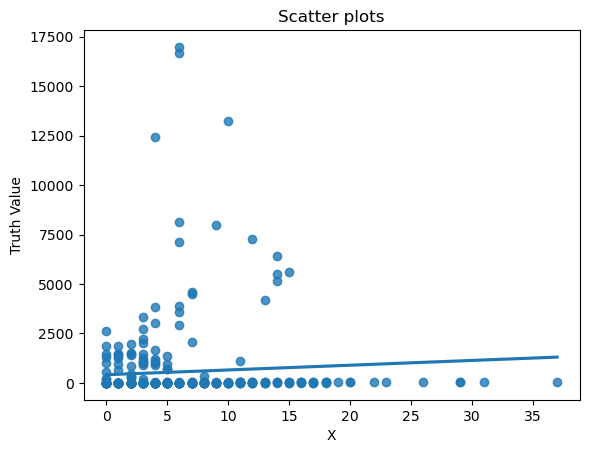

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x='new_hospitalized_patients', y='truth_value', data=df_ak, ci=None)
plt.title('Scatter plots')
plt.xlabel('X')
plt.ylabel('Truth Value')
plt.show()

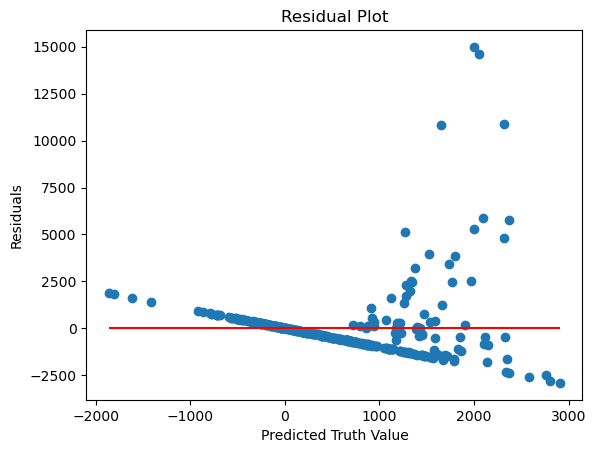

In [50]:
df_ak['predicted_truth_value'] = model.predict(X)
df_ak['residuals'] = df_ak['truth_value'] - df_ak['predicted_truth_value']

# Plot residuals
plt.scatter(df_ak['predicted_truth_value'], df_ak['residuals'])
plt.hlines(y=0, xmin=df_ak['predicted_truth_value'].min(), xmax=df_ak['predicted_truth_value'].max(), colors='red')
plt.title('Residual Plot')
plt.xlabel('Predicted Truth Value')
plt.ylabel('Residuals')
plt.show()

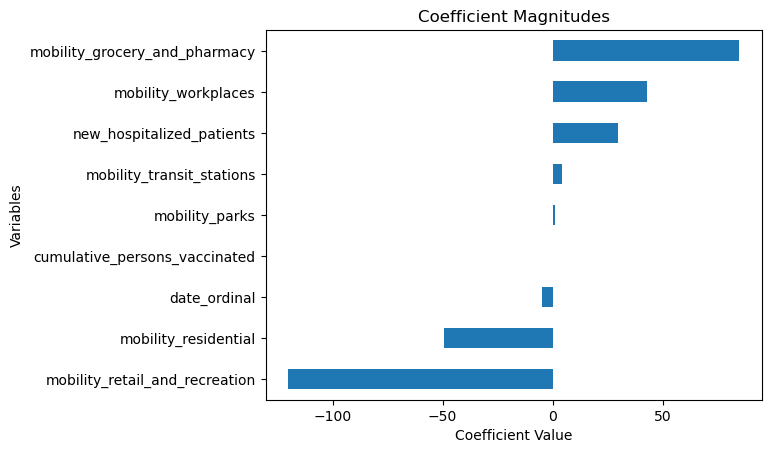

In [51]:
coef_df = pd.DataFrame(model.params)
coef_df.columns = ['Coefficient']
coef_df.drop('const', inplace=True)

# Plotting coefficients
coef_df.sort_values(by='Coefficient', ascending=True).plot(kind='barh', legend=False)
plt.title('Coefficient Magnitudes')
plt.xlabel('Coefficient Value')
plt.ylabel('Variables')
plt.show()